# Tiny Time Mixer Forecast

In [1]:
from src.tuning.load_estimators import load_all_forecasters, get_estimator

# This loads all sktime forecasters to be accessible by their class name -> don't need to run again
forecasters = load_all_forecasters()

### Set patient, model, and best params config

In [2]:
patient = "p04"

# Set model as sktime forecaster class name
model = "TinyTimeMixerForecaster"
forecaster_class = get_estimator(forecasters, model)

# Set relative path to config yaml file with params for model
config_path = "../../src/models/configs/TinyTimeMixerForecaster.yaml"


### Load data for one patient

In [3]:
from src.data.data_loader import BrisT1DDataLoader

# Split up data into day and night
loader = BrisT1DDataLoader(use_cached=True)

train_df = loader.train_data[loader.train_data["p_num"] == patient]
test_df = loader.validation_data[loader.validation_data["p_num"] == patient]

TIME_STEP_SIZE = (
    train_df["datetime"].iloc[1] - train_df["datetime"].iloc[0]
).components.minutes

if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
    error = """
    First time step is not 5 or 15 minutes. Look at the most common time step size.
    """

### Reduce columns and impute missing values on training set

In [4]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values

def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        # "hr-0:00", # -> has too many NaNs
        "steps-0:00",
        "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

In [5]:
y_train, X_train = reduce_features(train_df)

y_train.describe()

,bg-0:00
count,18777.000000
mean,7.757216
std,2.239097
min,2.200000
25%,6.300000
50%,7.400000
75%,9.000000
max,18.400000


In [6]:
X_train.describe()

,steps-0:00,cals-0:00,cob,carb_availability,insulin_availability,iob
count,18777.000000,18777.000000,18777.000000,18777.000000,18777.000000,18777.000000
mean,17.473026,5.659042,6.842803,3.198225,0.175299,3.199423
std,63.290036,4.462241,13.149223,5.689581,0.124130,2.320411
min,0.000000,0.910000,0.000000,0.000000,0.000000,0.062500
25%,0.000000,4.550000,0.000000,0.000000,0.087057,1.605483
50%,0.000000,4.550000,0.000000,0.000000,0.134103,2.420944
75%,0.000000,5.450000,9.024839,4.662605,0.229011,4.044839
max,673.000000,42.510000,265.600000,98.948242,0.925510,17.490950


### Load model with best params

In [7]:
from src.utils.config_loader import load_yaml_config

params = load_yaml_config(config_path)

forecaster = forecaster_class(**params)

### Fit model on training set

In [8]:
import numpy as np

HOURS_TO_PREDICT = 6
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE
fh = np.arange(1, NUM_STEPS + 1)

forecaster.fit(y=y_train, X=X_train, fh=fh)

TinyTimeMixerForecaster(training_args={'num_train_epochs': 10000000,
                                       'output_dir': 'test_output',
                                       'per_device_train_batch_size': 32})

In [9]:
forecaster.get_params()

{'broadcasting': False,
 'callbacks': None,
 'compute_metrics': None,
 'config': None,
 'model_path': 'ibm/TTM',
 'revision': 'main',
 'training_args': {'num_train_epochs': 10000000,
  'output_dir': 'test_output',
  'per_device_train_batch_size': 32},
 'use_source_package': False,
 'validation_split': 0.2}

### Plot predicted glucose levels

In [10]:
def plot_predicted(ax, forecaster, fh, X_night, test_period):
    predicted_bg = forecaster.predict(fh=fh, X=X_night)
    ax.plot(test_period.index, predicted_bg, label="Predicted glucose levels")


def plot_intervals(ax, forecaster, fh, X_night, test_period):
    pred_int = forecaster.predict_interval(fh=fh, X=X_night, coverage=0.95)[0][0.95]
    ax.plot(
        test_period.index,
        pred_int["upper"],
        label="Predicted upper interval",
        linestyle="--",
    )

    ax.plot(
        test_period.index,
        pred_int["lower"],
        label="Predicted lower interval",
        linestyle="--",
    )


def plot_quantiles(ax, forecaster, fh, X_night, test_period):
    quantiles = [0.95, 0.5, 0.05]
    pred_int = forecaster.predict_quantiles(fh=fh, X=X_night, alpha=quantiles)[
        "bg-0:00"
    ]

    ax.plot(
        test_period.index,
        pred_int[0.05],
        linestyle="--",
        label="0.05 quantile",
    )

    ax.plot(test_period.index, pred_int[0.50], label="0.5 quantile")

    ax.plot(
        test_period.index,
        pred_int[0.95],
        linestyle="--",
        label="0.95 quantile",
    )

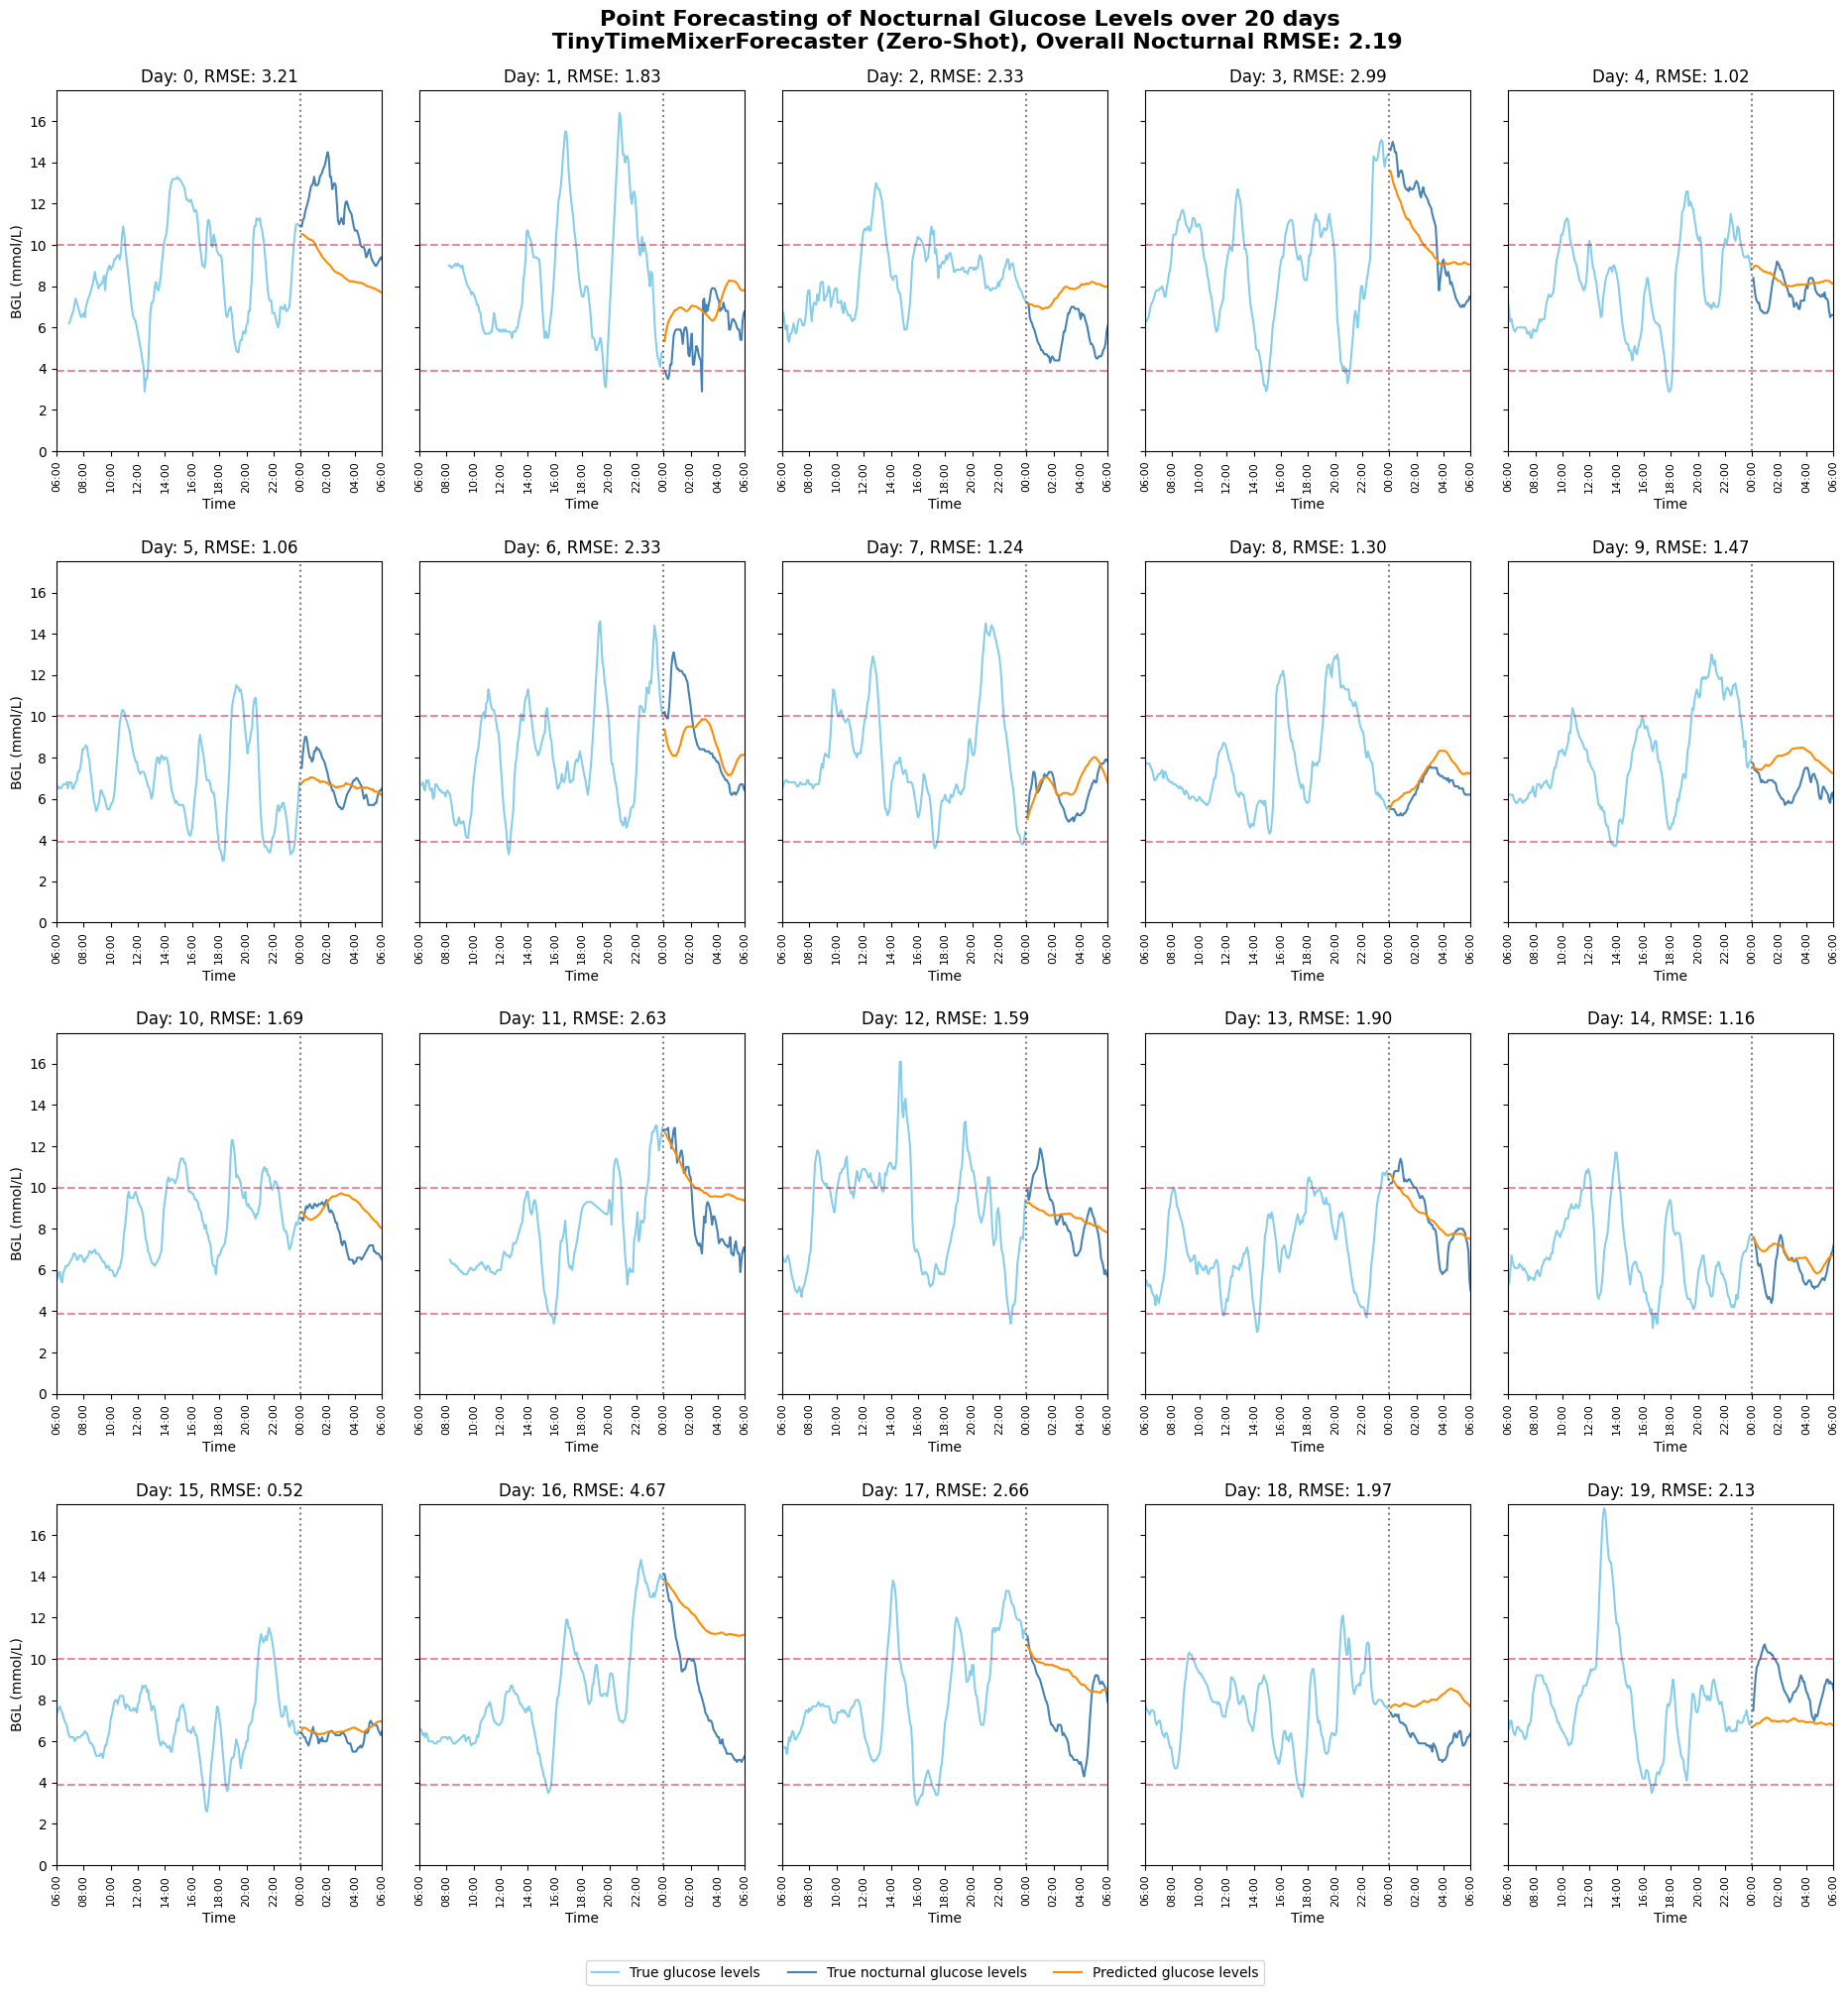

1.9836454532125747


In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create time index once (288 steps of 5 minutes from 6AM to 6AM next day)
time_index = pd.date_range(
    start='2024-01-01 06:00:00',
    end='2024-01-02 06:00:00',
    periods=289
)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Initialize the subplot counter
subplot_idx = 0
RMS_ERRORS = np.array([])
ERRORS_NIGHT = np.array([])

# Store lines for legend
legend_lines = []
legend_labels = []

# Loop over each day split and create one plot per day
for _, train_period, test_period in loader.get_validation_day_splits(patient):
    y_day, X_day = reduce_features(train_period)
    y_night, X_night = reduce_features(test_period)
    
    if X_day.isna().sum().any() > 0:
        print(X_day)
    if X_night.isna().sum().any() > 0:
        print(X_night)

    # Update the model with the true glucose levels for the day
    forecaster.update(y=y_day, X=X_day, update_params=False)

    ######## Determine MSE between predicted and true glucose levels ########
    predicted_bg = forecaster.predict(fh=fh, X=X_night)

    ######## Plot true glucose levels ########
    ax = axes[subplot_idx]
    daystart = 216 - len(y_day)
    day_line = ax.plot(
        time_index[daystart:len(y_day)+daystart],
        y_day["bg-0:00"],
        color="skyblue",
        label="True glucose levels",
    )[0]
    night_line = ax.plot(
        time_index[-72:],
        y_night["bg-0:00"],
        color="steelblue",
        linestyle="-",
        label="True nocturnal glucose levels",
    )[0]
    
    predicted_bg_ax = ax.plot(
        time_index[-72:],
        predicted_bg,
        color="darkorange",
        linestyle="-",
        label="Predicted glucose levels",
    )[0]
    
    # Format x-axis
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Show ticks every 2 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM
    
    mse = np.sqrt(np.mean((predicted_bg.values - y_night["bg-0:00"].values) ** 2))
    SE_NIGHT = (predicted_bg.values - y_night["bg-0:00"].values) ** 2
    ERRORS_NIGHT = np.append(ERRORS_NIGHT, SE_NIGHT)
    RMS_ERRORS = np.append(RMS_ERRORS, mse)      
    ax.set_title(f"Day: {subplot_idx}, RMSE: {mse:.2f}")
    
    ######## Plot predicted glucose levels ########
    # Only store legend items from first subplot
    if subplot_idx == 0:
        legend_lines.extend([day_line, night_line, predicted_bg_ax])
        legend_labels.extend(["True glucose levels", "True nocturnal glucose levels", "Predicted glucose levels"])
    
    # Set limits to show full 24-hour period
    ax.set_xlim(time_index[0], time_index[-1])

    # Add labels and formatting for each subplot (remove legend)
    ax.set_xlabel("Time", fontsize=10)
    # Hide y-axis labels for all plots except first in each row
    if subplot_idx % 5 != 0:  # If not first plot in row
        ax.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel("BGL (mmol/L)", fontsize=10)
    ax.set_ylim(0, 17.5)

    ax.tick_params(axis="x", rotation=90, labelsize=8)
    # Add horizontal reference lines
    ax.axhline(y=3.9, color='crimson', linestyle='--', alpha=0.5)    # Hypoglycemia threshold
    ax.axhline(y=10.0, color='crimson', linestyle='--', alpha=0.5)   # Hyperglycemia threshold
    ax.axvline(x=time_index[216], color='black', linestyle=':', alpha=0.5)   # Nocturnal start
    # Update the model with the true glucose levels for the night
    #forecaster.update(y=y_night, X=X_night, update_params=False)

    # Increment the subplot index for the next day
    subplot_idx += 1

TOTAL_TEST_RMSE = np.sqrt(np.mean(ERRORS_NIGHT))

fig.suptitle(
    f"Point Forecasting of Nocturnal Glucose Levels over 20 days \n {model} (Zero-Shot), Overall Nocturnal RMSE: {TOTAL_TEST_RMSE:.2f}",
    fontweight="bold",
    fontsize=16,
)

# Add a single legend outside the subplots
fig.legend(legend_lines, legend_labels, ncols=3, bbox_to_anchor=(0.65, 0.0))

# Adjust layout to avoid overlap with the legend
plt.tight_layout(rect=[0, 0, 0.95, 1], pad=2.0)

# Show the figure with multiple subplots
plt.show()


print(RMS_ERRORS.mean())

In [12]:
print(len(y_day))


216


In [13]:
print(len(y_night))

72


In [14]:
216+72

288

In [15]:
# Create time index once (288 steps of 5 minutes from 6AM to 6AM next day)
time_index = pd.date_range(
    start='2024-01-01 06:00:00',
    end='2024-01-02 06:00:00',
    periods=289
)

In [16]:
time_index[:]

DatetimeIndex(['2024-01-01 06:00:00', '2024-01-01 06:05:00',
               '2024-01-01 06:10:00', '2024-01-01 06:15:00',
               '2024-01-01 06:20:00', '2024-01-01 06:25:00',
               '2024-01-01 06:30:00', '2024-01-01 06:35:00',
               '2024-01-01 06:40:00', '2024-01-01 06:45:00',
               ...
               '2024-01-02 05:15:00', '2024-01-02 05:20:00',
               '2024-01-02 05:25:00', '2024-01-02 05:30:00',
               '2024-01-02 05:35:00', '2024-01-02 05:40:00',
               '2024-01-02 05:45:00', '2024-01-02 05:50:00',
               '2024-01-02 05:55:00', '2024-01-02 06:00:00'],
              dtype='datetime64[ns]', length=289, freq=None)

In [17]:
len(y_day)

216